This can be run [run on Google Colab using this link](https://colab.research.google.com/github/CS7150/CS7150-Homework_3/blob/main/HW3.1-Classifiers.ipynb)

## MNIST Classifiers (Convolutional Neural Networks and Fully Connected Networks)

<b>Optional</b>: Installing Wandb to see cool analysis of you code. You can go through the documentation here. We will do it for this assignment to get a taste of the GPU and CPU utilizations. If this is creating problems to your code, please comment out all the wandb lines from the notebook 

In [1]:
# Uncomment the below line to install wandb (optinal)
# !pip install wandb 
# Uncomment the below line to install torchinfo (https://github.com/TylerYep/torchinfo) [Mandatory]
# !pip install torchinfo

In [2]:
%%bash

wget -N https://cs7150.baulab.info/2022-Fall/data/mnist-classify.pth

--2023-10-19 22:02:51--  https://cs7150.baulab.info/2022-Fall/data/mnist-classify.pth
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 304 Not Modified
File ‘mnist-classify.pth’ not modified on server. Omitting download.



In [3]:
# Importing libraries
import matplotlib.pyplot as plt

import torch 
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split,Subset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import numpy as np
import datetime

from typing import List
from collections import OrderedDict
import math

In [4]:
import os
os.environ["WANDB_API_KEY"] = "76649aed02536ffcaa99378dd2c2cfa5fd558e78"

In [5]:
# Create an account at https://wandb.ai/site and paste the api key here (optional)
import wandb
wandb.init(project="hw3.1-ConvNets")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: surya-thiru001 (dl-hw). Use `wandb login --relogin` to force relogin


### Some helper functions to view network parameters

In [6]:
def view_network_parameters(model):
    # Visualise the number of parameters
    tensor_list = list(model.state_dict().items())
    total_parameters = 0
    print('Model Summary\n')
    for layer_tensor_name, tensor in tensor_list:
        total_parameters += int(torch.numel(tensor))
        print('{}: {} elements'.format(layer_tensor_name, torch.numel(tensor)))
    print(f'\nTotal Trainable Parameters: {total_parameters}!')

In [7]:
def view_network_shapes(model, input_shape):
    print(summary(model, input_size=input_shape))

### Fully Connected Network for Image Classification
Let's build a simple fully connected network!

In [8]:
def simple_fc_net():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1*28*28,8*28*28),
        nn.ReLU(),
        nn.Linear(8*28*28,16*14*14),
        nn.ReLU(),
        nn.Linear(16*14*14,32*7*7),
        nn.ReLU(),
        nn.Linear(32*7*7,288),
        nn.ReLU(),
        nn.Linear(288,64),
        nn.ReLU(),
        nn.Linear(64,10),
        nn.LogSoftmax())
    return model

In [9]:
fc_net = simple_fc_net()

In [10]:
view_network_parameters(fc_net)

Model Summary

1.weight: 4917248 elements
1.bias: 6272 elements
3.weight: 19668992 elements
3.bias: 3136 elements
5.weight: 4917248 elements
5.bias: 1568 elements
7.weight: 451584 elements
7.bias: 288 elements
9.weight: 18432 elements
9.bias: 64 elements
11.weight: 640 elements
11.bias: 10 elements

Total Trainable Parameters: 29985482!


In [11]:
view_network_parameters(fc_net)

Model Summary

1.weight: 4917248 elements
1.bias: 6272 elements
3.weight: 19668992 elements
3.bias: 3136 elements
5.weight: 4917248 elements
5.bias: 1568 elements
7.weight: 451584 elements
7.bias: 288 elements
9.weight: 18432 elements
9.bias: 64 elements
11.weight: 640 elements
11.bias: 10 elements

Total Trainable Parameters: 29985482!


In [12]:
from torchinfo import summary
summary(fc_net, input_size=(1, 1, 28,28))

/home/krishnamurthy.sur/.local/lib/python3.9/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 6272]                 4,923,520
├─ReLU: 1-3                              [1, 6272]                 --
├─Linear: 1-4                            [1, 3136]                 19,672,128
├─ReLU: 1-5                              [1, 3136]                 --
├─Linear: 1-6                            [1, 1568]                 4,918,816
├─ReLU: 1-7                              [1, 1568]                 --
├─Linear: 1-8                            [1, 288]                  451,872
├─ReLU: 1-9                              [1, 288]                  --
├─Linear: 1-10                           [1, 64]                   18,496
├─ReLU: 1-11                             [1, 64]                   --
├─Linear: 1-12                           [1, 10]      

<b>Exercise</b>: Now try to add different layers and see how the network parameters vary. Does adding layers reduce the parameters? Does the number of hidden neurons in the layers affect the total trainable parameters? 

<i>Add a few sentences on your observations while using various architectures</i>

In [13]:
# add layers

model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1*28*28,8*28*28),
        nn.ReLU(),
        nn.Linear(8*28*28,30*14*14),
        nn.ReLU(),
        nn.Linear(30*14*14,32*7*7),
        nn.ReLU(),
        nn.Linear(32*7*7,288),
        nn.ReLU(),
        nn.Linear(288,64),
        nn.ReLU(),
        nn.Linear(64,10),
        nn.LogSoftmax())
summary(model, input_size=(1, 1, 28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 6272]                 4,923,520
├─ReLU: 1-3                              [1, 6272]                 --
├─Linear: 1-4                            [1, 5880]                 36,885,240
├─ReLU: 1-5                              [1, 5880]                 --
├─Linear: 1-6                            [1, 1568]                 9,221,408
├─ReLU: 1-7                              [1, 1568]                 --
├─Linear: 1-8                            [1, 288]                  451,872
├─ReLU: 1-9                              [1, 288]                  --
├─Linear: 1-10                           [1, 64]                   18,496
├─ReLU: 1-11                             [1, 64]                   --
├─Linear: 1-12                           [1, 10]      

In [14]:
#Please type your answer here ...
"""
Adding more layers increases the parameters. Activation layers, which do not have any additional parameters,
do not add more parameters when added to the network.

Increasing the hidden neurons increases the total number of trainable parameters.
"""

'\nAdding more layers increases the parameters. Activation layers, which do not have any additional parameters,\ndo not add more parameters when added to the network.\n\nIncreasing the hidden neurons increases the total number of trainable parameters.\n'

### Convolutional Neural Network for Image Classification
Let's build a simple CNN to classify our images. 
<b> Exercise 3.1.1:</b> In the function below please add the conv/Relu/Maxpool layers to match the shape of FC-Net. Suppose at the some layer the FC-Net has `28*28*16` dimension, we want your conv_net to have `16 X 28 X 28` shape at the same numbered layer. <br>
<b>Extra-credit:</b> Try not to use MaxPool2d !

In [15]:
def simple_conv_net():
    model = nn.Sequential(
        # nn.Conv2d(1,16,kernel_size=3,padding=1),
        # nn.ReLU(),
        # nn.MaxPool2d(2,2),
        
        # TO-DO: Add layers below
        nn.Conv2d(1,8,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(8,16,kernel_size=6,padding=2,stride=2),
        nn.ReLU(),
        nn.Conv2d(16,32,kernel_size=2,padding=0,stride=2),
        nn.ReLU(),

        # TO-DO, what will your shape be after you flatten? Fill it in place of None
        nn.Flatten(),
        nn.Linear(1568,64),
        # Do not change the code below
        nn.ReLU(),
        nn.Linear(64,10),
        nn.LogSoftmax())
    return model

In [16]:
conv_net = simple_conv_net()

In [17]:
view_network_parameters(conv_net)

Model Summary

0.weight: 72 elements
0.bias: 8 elements
2.weight: 4608 elements
2.bias: 16 elements
4.weight: 2048 elements
4.bias: 32 elements
7.weight: 100352 elements
7.bias: 64 elements
9.weight: 640 elements
9.bias: 10 elements

Total Trainable Parameters: 107850!


In [18]:
view_network_shapes(conv_net, input_shape=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 8, 28, 28]            80
├─ReLU: 1-2                              [1, 8, 28, 28]            --
├─Conv2d: 1-3                            [1, 16, 14, 14]           4,624
├─ReLU: 1-4                              [1, 16, 14, 14]           --
├─Conv2d: 1-5                            [1, 32, 7, 7]             2,080
├─ReLU: 1-6                              [1, 32, 7, 7]             --
├─Flatten: 1-7                           [1, 1568]                 --
├─Linear: 1-8                            [1, 64]                   100,416
├─ReLU: 1-9                              [1, 64]                   --
├─Linear: 1-10                           [1, 10]                   650
├─LogSoftmax: 1-11                       [1, 10]                   --
Total params: 107,850
Trainable params: 107,850
Non-trainable params: 0
T

<b>Exercise 3.1.2</b>: Why is the final layer a log softmax? What is a softmax function? Can we use ReLU instead of softmax? If yes, what would you do different? If not, tell us why. If you think there is a different answer, feel free to use this space to chart it down

We use softmax to produce a probability of distributions as an output, which apart from being a very nice way of expressing discrete outputs, is also the output format required by popular loss functions.

ReLU does not have the above properties and is therefore not a good output function. An example illustration is shown in the following cell.

In machine learning, when optimization involving probabilities are done, we generally use the log of the probabilities instead of the raw probabilities, as done by the log-softmax function. This has a number of practical advantages:
1. Multiplication of probabilities (common in MLE) become addition of log probabilities, which is a operation with significantly lesser time complexity
2. Log probabilities are numerically stable. With raw probabilities [0,1] there is a higher chance of precision underflow.

Text(0.5, 1.0, 'relu')

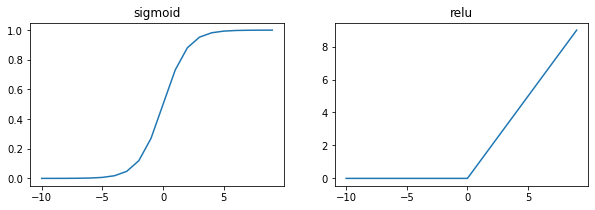

In [19]:
x = torch.arange(-10, 10)
ys = F.sigmoid(x)
yr = F.relu(x)

fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(x, ys)
ax[0].set_title("sigmoid")
ax[1].plot(x, yr)
ax[1].set_title("relu")

<b>Exercise 3.1.3</b>: What is the ratio of number of parameters of Conv-net to number of parameters of FC-Net <br>
$\frac{p_{conv-net}}{p_{fc-net}}$ = Fill your answer <br>
Do you see the difference ?! 

0.0036

<b>Exercise 3.1.4</b>: Now try to add different layers and see how the network parameters vary. Does adding layers reduce the parameters? Does the number of hidden neurons in the layers affect the total trainable parameters? Use the `build_custom_fc_net` function given below. You do not have to understand the working of it. 

<i>Add a few sentences on your observations while using various architectures</i>

In [20]:
def build_custom_fc_net(inp_dim: int, out_dim: int, hidden_fc_dim: List[int]):
    '''
    Inputs :
    
    inp_dim: Shape of the input dimensions (in MNIST case 28*28)
    out_dim: Desired classification classes (in MNIST case 10)
    hidden_fc_dim: List of the intermediate dimension shapes (list of integers). Try different values and see the shapes'
    
    Return: nn.Sequential (final custom model)
    '''
    assert type(hidden_fc_dim) == list, "Please define hidden_fc_dim as list of integers"
    layers = []
    layers.append((f'flatten', nn.Flatten()))
    # If no hidden layer is required
    if len(hidden_fc_dim) == 0:
        layers.append((f'linear',nn.Linear(math.prod(inp_dim),out_dim)))
        layers.append((f'activation',nn.LogSoftmax()))
    else:
        # Loop over hidden dimensions and add layers
        for idx, dim in enumerate(hidden_fc_dim):
            if idx == 0:
                layers.append((f'linear_{idx+1}',nn.Linear(math.prod(inp_dim),dim)))
                layers.append((f'activation_{idx+1}',nn.ReLU()))
            else:
                layers.append((f'linear_{idx+1}',nn.Linear(hidden_fc_dim[idx-1],dim)))
                layers.append((f'activation_{idx+1}',nn.ReLU()))
        layers.append((f'linear_{idx+2}',nn.Linear(dim,out_dim)))
        layers.append((f'activation_{idx+2}',nn.LogSoftmax()))
        
    model =  nn.Sequential(OrderedDict(layers))
    return model

# TO-DO build different networks (atleast 3) and see the parameters
#(You don't have to understand the function above. It is a generic way to build a FC-Net)


fc_net_custom1 = build_custom_fc_net(inp_dim=(1,28,28), out_dim=10, hidden_fc_dim=[128,64,32])
view_network_parameters(fc_net_custom1)

fc_net_custom2 = build_custom_fc_net(inp_dim=(1,28,28), out_dim=10, hidden_fc_dim=[128,128,32])
view_network_parameters(fc_net_custom2)

fc_net_custom3 = build_custom_fc_net(inp_dim=(1,28,28), out_dim=10, hidden_fc_dim=[128,64,64,32])
view_network_parameters(fc_net_custom3)

Model Summary

linear_1.weight: 100352 elements
linear_1.bias: 128 elements
linear_2.weight: 8192 elements
linear_2.bias: 64 elements
linear_3.weight: 2048 elements
linear_3.bias: 32 elements
linear_4.weight: 320 elements
linear_4.bias: 10 elements

Total Trainable Parameters: 111146!
Model Summary

linear_1.weight: 100352 elements
linear_1.bias: 128 elements
linear_2.weight: 16384 elements
linear_2.bias: 128 elements
linear_3.weight: 4096 elements
linear_3.bias: 32 elements
linear_4.weight: 320 elements
linear_4.bias: 10 elements

Total Trainable Parameters: 121450!
Model Summary

linear_1.weight: 100352 elements
linear_1.bias: 128 elements
linear_2.weight: 8192 elements
linear_2.bias: 64 elements
linear_3.weight: 4096 elements
linear_3.bias: 64 elements
linear_4.weight: 2048 elements
linear_4.bias: 32 elements
linear_5.weight: 320 elements
linear_5.bias: 10 elements

Total Trainable Parameters: 115306!


While both adding layers and adding more parameters result in an increased number of trainable parameters, the comparison between them might vary based on the type of network. 

But generally for a fixed network, adding parameters can have more dramatic increase in parameters than adding layers. In the example above, I have illustrated this by doubling the 64 unit layer by:
1. adding another 64 units to the same layer
2. adding another layer with 64 units

We see that 1. introduces more trainable parameters.

## Let's train the models to see their performace

In [21]:
# downloading mnist into folder
data_dir = 'data' # make sure that this folder is created in your working dir
# transform the PIL images to tensor using torchvision.transform.toTensor method
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
test_data  = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
print(f'Datatype of the dataset object: {type(train_data)}')
# check the length of dataset
n_train_samples = len(train_data)
print(f'Number of samples in training data: {len(train_data)}')
print(f'Number of samples in test data: {len(test_data)}')
# Check the format of dataset
#print(f'Foramt of the dataset: \n {train_data}')

val_split = .2
batch_size=256 

train_data_, val_data = random_split(train_data, [int(n_train_samples*(1-val_split)), int(n_train_samples*val_split)])

train_loader = torch.utils.data.DataLoader(train_data_, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

Datatype of the dataset object: <class 'torchvision.datasets.mnist.MNIST'>
Number of samples in training data: 60000
Number of samples in test data: 10000


### Displaying the loaded dataset

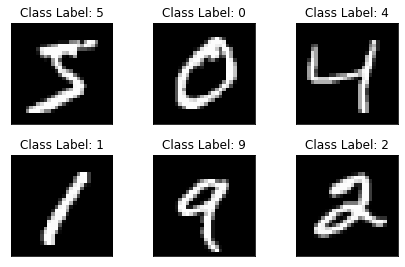

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(train_data[i][0][0], cmap='gray', interpolation='none')
  plt.title("Class Label: {}".format(train_data[i][1]))
  plt.xticks([])
  plt.yticks([])


## Function to train the model

In [23]:
def train_model(model, train_loader, device, loss_fn, optimizer, input_dim=(-1,1,28,28)):
    model.train()
    # Initiate a loss monitor
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning and not supervised classification)
    for images, labels in train_loader: # the variable `labels` will be used for customised training
        # reshape input
        images = torch.reshape(images,input_dim)
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        loss = loss_fn(predicted, labels)
        # Backward pass (back propagation)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       
        wandb.log({"Training Loss": loss})
        wandb.watch(model)
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

## Function to test the model

In [24]:
# Testing Function
def test_model(model, test_loader, device, loss_fn, input_dim=(-1,1,28,28)):
    # Set evaluation mode for encoder and decoder
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        predicted = []
        actual = []
        for images, labels in test_loader:
            # reshape input
            images = torch.reshape(images,input_dim)
            images = images.to(device)
            labels = labels.to(device)
            ## predict the label
            pred = model(images)
            # Append the network output and the original image to the lists
            predicted.append(pred.cpu())
            actual.append(labels.cpu())
        # Create a single tensor with all the values in the lists
        predicted = torch.cat(predicted)
        actual = torch.cat(actual) 
        # Evaluate global loss
        val_loss = loss_fn(predicted, actual)
    return val_loss.data

Before we start training let's delete the huge FC-Net we built and build a reasonable FC-Net (You learnt why such larger networks are not reasonable in the previous notebook)

In [25]:
del fc_net, fc_net_custom1, fc_net_custom2, fc_net_custom3
torch.cuda.empty_cache()
# Building a reasonable fully connected network
fc_net = build_custom_fc_net(inp_dim=(1,28,28), out_dim=10, hidden_fc_dim=[128,64,32])

<b>Exercise 3.1.5:</b> 
Code the `weight_init_xavier` function by referring to https://pytorch.org/docs/stable/nn.init.html. Replace the weight initializations to your own function.


In [26]:
### Set the random seed for reproducible results
torch.manual_seed(0)
# Choosing a device based on the env and torch setup
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

def weight_init_zero(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.constant_(m.weight, 0.0)
        m.bias.data.fill_(0.01)

def weight_init_xavier(m):
    '''
    TO-DO: please add code below to add xavier uniform initialization and remove the 'pass'
    '''
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    
fc_net.to(device)
conv_net.to(device)

# Apply the weight initialization
fc_net.apply(weight_init_zero)
conv_net.apply(weight_init_zero)

# Apply the xavier weight initialization
#TO-DO: Add your function here
fc_net.apply(weight_init_xavier)
conv_net.apply(weight_init_xavier)


# Take the parameters for optimiser
params_to_optimize_fc = [
    {'params': fc_net.parameters()}
]

params_to_optimize_conv = [
    {'params': conv_net.parameters()}
]
### Define the loss function
loss_fn = torch.nn.NLLLoss()
### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

optim_fc = torch.optim.Adam(params_to_optimize_fc, lr=lr, weight_decay=1e-05)
optim_conv = torch.optim.Adam(params_to_optimize_conv, lr=lr, weight_decay=1e-05)
num_epochs = 30
wandb.config = {
  "learning_rate": lr,
  "epochs": num_epochs,
  "batch_size": batch_size
}

Selected device: cuda


# Training the Convolutional Neural Networks

In [27]:
print('Conv Net training started')
history_conv = {'train_loss':[],'val_loss':[]}
start_time = datetime.datetime.now()

for epoch in range(num_epochs):
    ### Training 
    
    train_loss = train_model(
        model=conv_net,
        train_loader=train_loader,
        device=device,
        loss_fn=loss_fn,
        optimizer=optim_conv,
        input_dim=(-1,1,28,28))
    ### Validation  (use the testing function)
    val_loss = test_model(
        model=conv_net,
        test_loader=test_loader,
        device=device,
        loss_fn=loss_fn,
        input_dim=(-1,1,28,28))
    # Print Losses 
    print(f'Epoch {epoch+1}/{num_epochs} : train loss {train_loss:.3f} \t val loss {val_loss:.3f}')
    history_conv['train_loss'].append(train_loss)
    history_conv['val_loss'].append(val_loss)
    
    
print(f'Conv Net training done in {(datetime.datetime.now()-start_time).total_seconds():.3f} seconds!')

Conv Net training started


/home/krishnamurthy.sur/.local/lib/python3.9/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/krishnamurthy.sur/.local/lib/python3.9/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1/30 : train loss 0.513 	 val loss 0.173
Epoch 2/30 : train loss 0.134 	 val loss 0.099
Epoch 3/30 : train loss 0.084 	 val loss 0.068
Epoch 4/30 : train loss 0.061 	 val loss 0.061
Epoch 5/30 : train loss 0.051 	 val loss 0.050
Epoch 6/30 : train loss 0.043 	 val loss 0.046
Epoch 7/30 : train loss 0.036 	 val loss 0.044
Epoch 8/30 : train loss 0.031 	 val loss 0.046
Epoch 9/30 : train loss 0.027 	 val loss 0.043
Epoch 10/30 : train loss 0.024 	 val loss 0.048
Epoch 11/30 : train loss 0.021 	 val loss 0.036
Epoch 12/30 : train loss 0.019 	 val loss 0.039


wandb: ERROR Summary data exceeds maximum size of 10.4MB. Dropping it.


Epoch 13/30 : train loss 0.015 	 val loss 0.044
Epoch 14/30 : train loss 0.014 	 val loss 0.051
Epoch 15/30 : train loss 0.012 	 val loss 0.042
Epoch 16/30 : train loss 0.013 	 val loss 0.049
Epoch 17/30 : train loss 0.009 	 val loss 0.040
Epoch 18/30 : train loss 0.008 	 val loss 0.046
Epoch 19/30 : train loss 0.010 	 val loss 0.052
Epoch 20/30 : train loss 0.008 	 val loss 0.053
Epoch 21/30 : train loss 0.008 	 val loss 0.048
Epoch 22/30 : train loss 0.006 	 val loss 0.049
Epoch 23/30 : train loss 0.006 	 val loss 0.054
Epoch 24/30 : train loss 0.007 	 val loss 0.054
Epoch 25/30 : train loss 0.007 	 val loss 0.042
Epoch 26/30 : train loss 0.004 	 val loss 0.059
Epoch 27/30 : train loss 0.003 	 val loss 0.051
Epoch 28/30 : train loss 0.004 	 val loss 0.063
Epoch 29/30 : train loss 0.004 	 val loss 0.057
Epoch 30/30 : train loss 0.005 	 val loss 0.062
Conv Net training done in 682.806 seconds!


### Visualizing Training Progress of Conv Net (Also check out your wandb.ai homepage)

Text(0, 0.5, 'Negative Log Likelihood Loss')

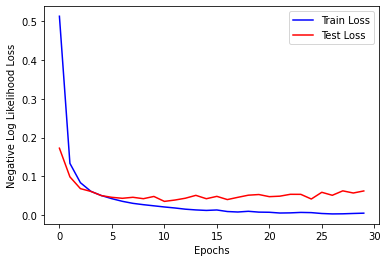

In [28]:
fig = plt.figure()
plt.plot(history_conv['train_loss'], color='blue')
plt.plot(history_conv['val_loss'], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss')

### Visualizing Predictions of Conv Net

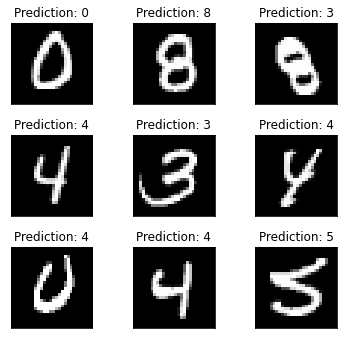

In [29]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    example_data = example_data.to(device)
    output = conv_net(example_data)
example_data = example_data.cpu().detach().numpy()
fig = plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray',interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

# Training the Fully-Connected Neural Networks

<b>Exercise 3.1.6:</b> Train the fully connected neural network and analyse it

In [30]:
#TO-DO:Train the fc_net here
print('FC Net training started')
history_fc = {'train_loss':[],'val_loss':[]}
start_time = datetime.datetime.now()

for epoch in range(num_epochs):
    ### Training     
    train_loss = train_model(
        model=fc_net,
        train_loader=train_loader,
        device=device,
        loss_fn=loss_fn,
        optimizer=optim_fc,
        input_dim=(-1,1,28,28))
    ### Validation  (use the testing function)
    val_loss = test_model(
        model=fc_net,
        test_loader=test_loader,
        device=device,
        loss_fn=loss_fn,
        input_dim=(-1,1,28,28))
    # Print Losses 
    print(f'Epoch {epoch+1}/{num_epochs} : train loss {train_loss:.3f} \t val loss {val_loss:.3f}')
    history_fc['train_loss'].append(train_loss)
    history_fc['val_loss'].append(val_loss)
        
print(f'FC Net training done in {(datetime.datetime.now()-start_time).total_seconds():.3f} seconds!')

FC Net training started
Epoch 1/30 : train loss 0.520 	 val loss 0.216
Epoch 2/30 : train loss 0.183 	 val loss 0.160
Epoch 3/30 : train loss 0.129 	 val loss 0.128
Epoch 4/30 : train loss 0.102 	 val loss 0.115
Epoch 5/30 : train loss 0.082 	 val loss 0.100
Epoch 6/30 : train loss 0.068 	 val loss 0.101
Epoch 7/30 : train loss 0.055 	 val loss 0.098
Epoch 8/30 : train loss 0.047 	 val loss 0.093
Epoch 9/30 : train loss 0.040 	 val loss 0.088
Epoch 10/30 : train loss 0.034 	 val loss 0.085
Epoch 11/30 : train loss 0.027 	 val loss 0.094
Epoch 12/30 : train loss 0.023 	 val loss 0.085
Epoch 13/30 : train loss 0.021 	 val loss 0.093
Epoch 14/30 : train loss 0.016 	 val loss 0.086
Epoch 15/30 : train loss 0.013 	 val loss 0.105
Epoch 16/30 : train loss 0.015 	 val loss 0.099
Epoch 17/30 : train loss 0.012 	 val loss 0.100
Epoch 18/30 : train loss 0.008 	 val loss 0.099
Epoch 19/30 : train loss 0.008 	 val loss 0.099
Epoch 20/30 : train loss 0.005 	 val loss 0.101
Epoch 21/30 : train loss 

## Visualizing Training Progress of FC Net (Check out your wandb.ai project webpage)

Text(0, 0.5, 'Negative Log Likelihood Loss')

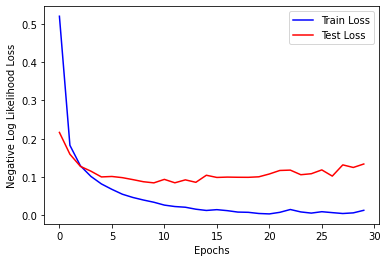

In [31]:
# TODO - Visualize the training progress of fc_net
fig = plt.figure()
plt.plot(history_fc['train_loss'], color='blue')
plt.plot(history_fc['val_loss'], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss')

## Visualizing Predictions of FC Net

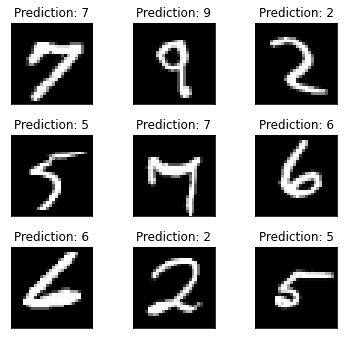

In [32]:
# TODO - Visualise the predictions of fc_net
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    example_data = example_data.to(device)
    output = fc_net(example_data)
example_data = example_data.cpu().detach().numpy()
fig = plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray',interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

<b>Exercise 3.1.7</b>: What are the training times for each of the model? Did both the models take similar times? If yes, why? Shouldn't CNN train faster given it's number of weights to train?

In [33]:
#Please type your answer here ...
"""
While it is true that CNNs have fewer parmeters, it is because they share their parameters
as they perform their convolution operation across the image.

This convolution operation has a much higher time complexity compared 
to the matrix multiplication used at each layer in the feed forward network.
"""

'\nWhile it is true that CNNs have fewer parmaters, it is because they share their parameters\nas they perform their convolution operation across the image.\n\nThis convolution operation has a much higher time complexity compared \nto the matrix multiplication used at each layer in the feed forward network.\n'

## Let's see how the models perform under translation

In principle, one of the advantages of convolutions is that they are equivariant under translation which means that a function composed out of convolutions should invariant under translation.

<b>Exercise 3.1.8</b>: In practice, however, we might not see perfect invariance under translation.  What aspect of our network leads to imperfect invariance?


Several reasons can cause the model to perform poorly under translation. 
1. When translation is manually introduced, the addition of padding elements can cause the network distribution to shift resulting in poor performance
2. Sometimes severe translation can cause the object of interest to leave the image frame, resulting in loss of information
3. In rare cases the feed forward layers at the end of the network can become a bottleneck for invariance
4. Layers like max pooling perform downsampling at the local level which can change how the features look when the image is translated. This can have a minor effect on invariance.  // source: chatgpt
5. While CNNs are equivariant, if translation of an image changes its distribution drastically from the training set (probably from poor training data diversity), it can affect the performance of the model.


We will next measure the sensitivity  of the convolutional network to translation in practice, and we will compare it to the fully-connected version. 

In [34]:
## function to check accuracies for unit translation
def shiftVsAccuracy(model, test_loader, device, loss_fn, shifts = 12, input_dim=(-1,1,28,28)):
    # Set evaluation mode for encoder and decoder
    accuracies = []
    shifted = []
    for i in range(-shifts,shifts):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            predicted = []
            actual = []
            for images, labels in test_loader:
                # reshape input
                images = torch.roll(images,shifts=i, dims=2)
                if i == 0:
                    pass
                elif i > 0:
                    images[:,:,:i,:] = 0
                else:
                    images[:,:,i:,:] = 0
                images = torch.reshape(images,input_dim)
                images = images.to(device)
                labels = labels.to(device)
                ## predict the label
                pred = model(images)
                # Append the network output and the original image to the lists
                _ , pred = torch.max(pred.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                predicted.append(pred.cpu())
                actual.append(labels.cpu())  
            shifted.append(images[0][0].cpu())
            acc = 100 * correct // total
            accuracies.append(acc)
    return accuracies,shifted

In [35]:
accuracies,shifted = shiftVsAccuracy(
        model=conv_net,
        test_loader=test_loader,
        device=device,
        shifts=12,
        loss_fn=loss_fn,
        input_dim=(-1,1,28,28))

Text(0.5, 1.0, 'Accuracy Vs Translation')

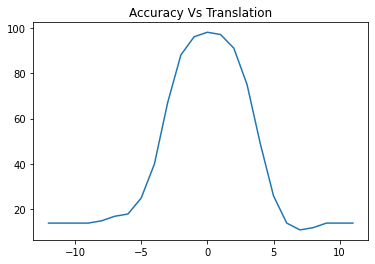

In [36]:
shifts = np.arange(-12,12)
plt.plot(shifts,accuracies)
plt.title('Accuracy Vs Translation')

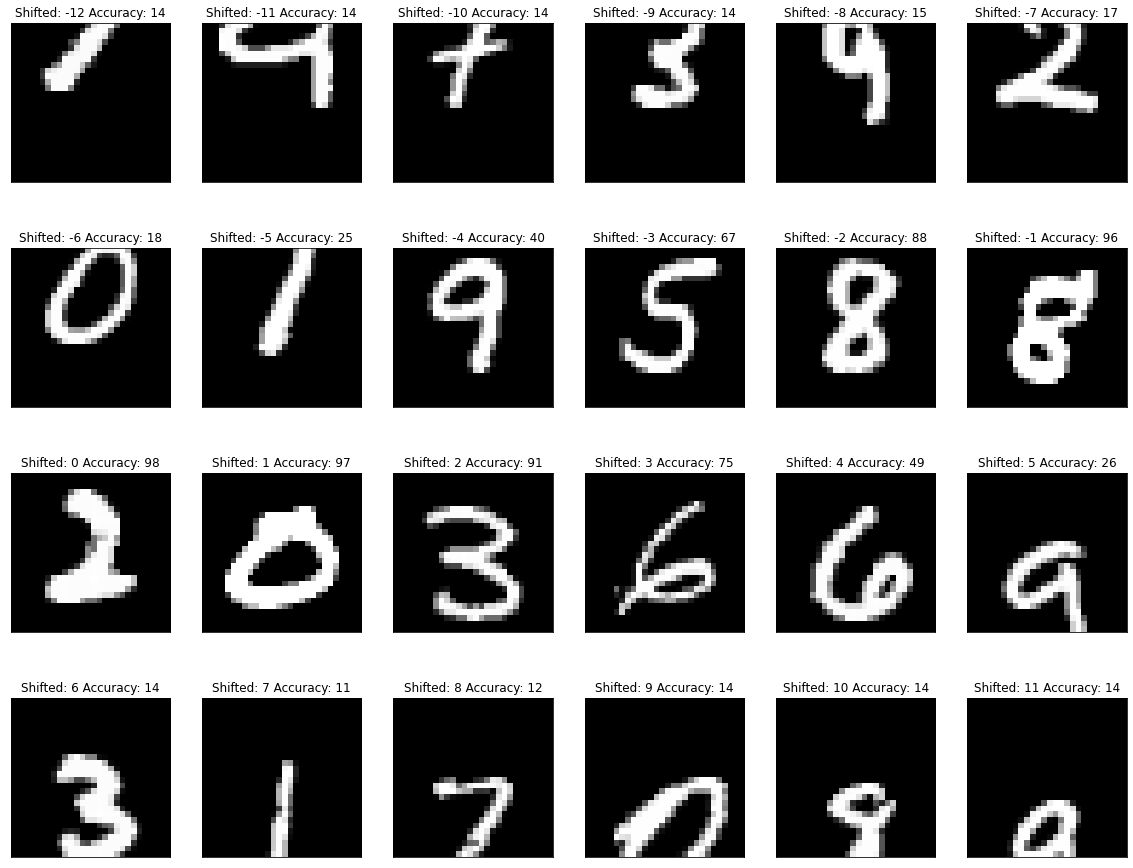

In [37]:
fig = plt.figure(figsize=(20,20))
plt_num = 0
for i in range(-12,12):
    plt.subplot(5,6,plt_num+1)
    plt.imshow(shifted[plt_num], cmap='gray',interpolation='none')
    plt.title(f"Shifted: {i} Accuracy: {accuracies[plt_num]}")
    plt.xticks([])
    plt.yticks([])
    plt_num+=1

<b>Exercise 3.1.8:</b>
Do the same for FC-Net and plot the accuracies. Is the rate of accuracy degradation same as Conv-Net? Can you justify why this happened? <br>
Clue: You might want to look at the way convolution layers process information

In [38]:
# To-DO Write your code below
accuracies,shifted = shiftVsAccuracy(
        model=fc_net,
        test_loader=test_loader,
        device=device,
        shifts=12,
        loss_fn=loss_fn,
        input_dim=(-1,1,28,28))

/home/krishnamurthy.sur/.local/lib/python3.9/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Text(0.5, 1.0, 'Accuracy Vs Translation')

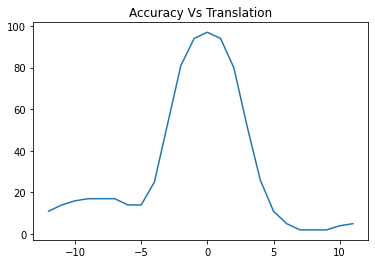

In [39]:
shifts = np.arange(-12,12)
plt.plot(shifts,accuracies)
plt.title('Accuracy Vs Translation')

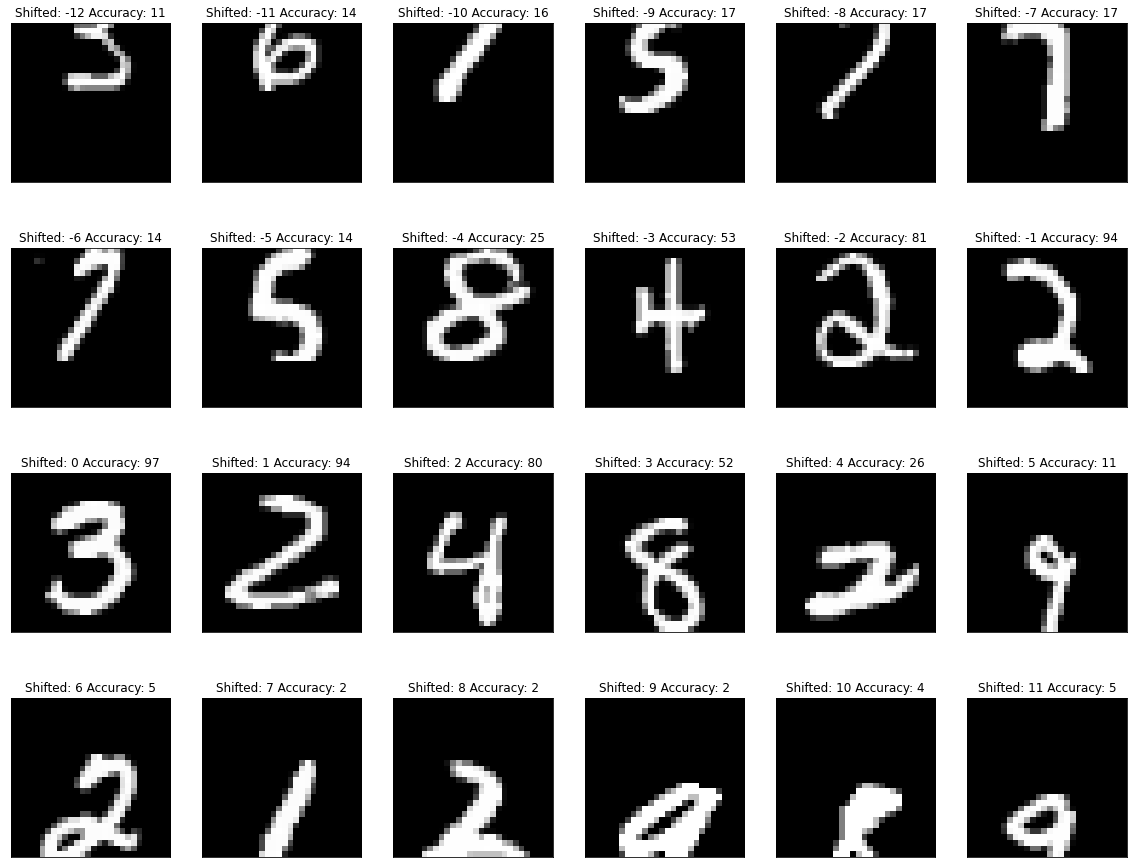

In [40]:
fig = plt.figure(figsize=(20,20))
plt_num = 0
for i in range(-12,12):
    plt.subplot(5,6,plt_num+1)
    plt.imshow(shifted[plt_num], cmap='gray',interpolation='none')
    plt.title(f"Shifted: {i} Accuracy: {accuracies[plt_num]}")
    plt.xticks([])
    plt.yticks([])
    plt_num+=1

The drop in accuracy is slightly sharper in the feed-forward layers, compared to CNN which is a little gradual. 

The convolution operation that obtains the cross correlation of features by convolving over the input image makes it translation invariant. 

However, feed-forward networks look for certain features in specific spatial positions which is often impractical for images.

However, with the important features of the image being cut off from the image after severe translation the network's performance will begin to fall, which can be observed above.

I also hypothesize that the sharper drop for shifting down compared to shifting up in FCN is because of the fact that many of the useful features of digits are present in the lower half of the image, which the FCN model is explicitly looking for.